In [1]:
import os
import sys
import json
import argparse
from sklearn.model_selection import KFold

import torch
import torchmetrics
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.nn.modules.loss import BCELoss
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW, AutoConfig, AutoModel, AutoTokenizer, get_linear_schedule_with_warmup


class TransformerModule(LightningModule):
    def __init__(
            self,
            model_name_or_path: str,
            num_labels: int = 4,
            learning_rate: float = 3e-5,
            adam_epsilon: float = 1e-8,
            warmup_steps: int = 0,
            weight_decay: float = 0.0,
            max_seq_length: int = 512,
            batch_size: int = 4,
            **kwargs,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.config = AutoConfig.from_pretrained(model_name_or_path)
        self.model = AutoModel.from_pretrained(model_name_or_path, config=self.config)
        self.classifier = torch.nn.Linear(768, 4)
        self.sigmoid = torch.nn.Sigmoid()
        self.loss_fn = BCELoss()
        self.metric_acc = torchmetrics.Accuracy()
        self.metric_f1 = torchmetrics.F1()
        self.num_labels = num_labels
        self.batch_size = batch_size
        self.tokenizer = AutoTokenizer.from_pretrained(
            model_name_or_path, use_fast=True, max_length=max_seq_length,
        )

    def forward(self, **inputs):
        # inputs['input_ids'].shape -> [batch_size, max_len]
        output = self.model(inputs["input_ids"])
        # cls_output_state.shape -> [batch_size, 768]
        cls_output_state = output["last_hidden_state"][inputs["input_ids"] == self.tokenizer.cls_token_id]
        # logits.shape -> [batch_size, num_labels] -> [num_labels * batch_size]
        logits = self.classifier(cls_output_state)
        probs = self.sigmoid(logits)
        probs_flat = probs.view(-1)
        # labels_flat.shape -> [num_labels * batch_size]
        labels = inputs["labels"]
        # print("labels",labels)
        if 'labels_float' not in inputs:
            temp_float = [float(l) for l in labels]
            inputs['labels_float']=torch.tensor(temp_float)
            # print("labels_float", inputs["labels_float"])
        labels_float = inputs["labels_float"]
        labels_flat = labels_float.view(-1)
        loss = self.loss_fn(probs_flat, labels_flat)
        return loss, probs, labels

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        loss = outputs[0]
        acc = self.metric_acc(outputs[1].view(-1), outputs[2].view(-1))
        self.log("loss", loss)
        self.log("acc", acc)
        return loss

    def validation_step(self, batch, batch_idx, dataloader_idx=0):
        outputs = self(**batch)
        val_loss, probs, labels = outputs
        preds = torch.round(probs)
        # print("predictions val", preds)
        return {"loss": val_loss, "preds": preds, "labels": labels}

    def validation_epoch_end(self, outputs):
        preds = torch.cat([x["preds"] for x in outputs]).detach().cpu()
        labels = torch.cat([x["labels"] for x in outputs]).detach().cpu()
        loss = torch.stack([x["loss"] for x in outputs]).mean()
        self.log("val_loss", loss)
        val_acc = self.metric_acc(preds.view(-1), labels.view(-1))
        val_f1 = self.metric_f1(preds.view(-1), labels.view(-1))
        self.log("val_acc", val_acc, prog_bar=True)
        self.log("val_f1", val_f1, prog_bar=True)
        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        outputs = self(**batch)
        _, probs, _ = outputs
        preds = torch.round(probs)
        # print("prediction", preds)
        return {"preds": preds}
        
    def setup(self, stage=None) -> None:
        if stage != "fit":
            return
        train_loader = self.train_dataloader()
        tb_size = self.hparams.batch_size * max(1, len(self.trainer.gpus) if self.trainer.gpus else 0)
        ab_size = self.trainer.accumulate_grad_batches * float(self.trainer.max_epochs)
        self.total_steps = (len(train_loader.dataset) // tb_size) // ab_size

    def configure_optimizers(self):
        """Prepare optimizer and schedule (linear warmup and decay)"""
        model = self.model
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)

        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.hparams.warmup_steps,
            num_training_steps=self.total_steps,
        )
        scheduler = {"scheduler": scheduler, "interval": "step", "frequency": 1}
        return [optimizer], [scheduler]

### Process DF and predict 5 fold cross validation model

In [2]:
import pandas as pd
import re

In [3]:
df = pd.read_csv('final-experiment.csv')

In [4]:
df.columns

Index(['category', 'comments', 'descriptions', 'difficulty_rating', 'endDate',
       'endTime', 'experiment_id', 'image', 'is_data_visualization',
       'languages', 'minivlat_answers', 'minivlat_time', 'prolific_id',
       'reaction_times', 'self_understanding', 'startDate', 'startTime',
       'timeSpent', 'topic', 'trial_number', 'desc_type', 'minivlat_score',
       'num_words', 'caption', 'alttext', 'char_count', 'num_words_caption',
       'num_words_alttext', 'desc_caption_jaccard', 'desc_alttext_jaccard',
       'desc_caption_sbert', 'desc_alttext_sbert', 'jaccard_alttext_caption',
       'sbert_alttext_caption', 'question1', 'question10', 'question11',
       'question12', 'question2', 'question3', 'question4', 'question5',
       'question6', 'question7', 'question8', 'question9'],
      dtype='object')

In [18]:
descriptions = df['descriptions'].tolist()
corpus_count = 1000
all_sentences = []
for desc in descriptions:
    sentences = re.split(r"(?<=\.)(\s)(?=[A-Z])", desc)
    formatted_sentence = [i for i in sentences if i != " "]
    for i in range(len(formatted_sentence)//2+1):
      sent_id = int(2*i)
      all_sentences.append({
          "corpus_id":corpus_count,
          "sent_id":int(i),
          "text": sentences[sent_id]+sentences[sent_id+1] if i!= len(sentences)//2 else sentences[sent_id],
          "labels":[-1, -1, -1, -1]
      })
    corpus_count+=1 

In [3]:
model_name = "allenai/scibert_scivocab_uncased"
out_dir = os.path.join('all_data', model_name.replace('/', '_'))
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, max_length=512)

models = {}
for i in range(5):
    out_subdir = os.path.join(out_dir, f'fold_{i:02d}', 'checkpoints')
    filename = os.listdir(out_subdir)[0]
    model_path = out_subdir +'/'+filename
    # print("model path", model_path)
    model = TransformerModule.load_from_checkpoint(model_path)
    model.eval()
    models[i] = model
    # with torch.no_grad():
    #     all = model(input_ids=input_ids, labels=sentence['labels'])
    #     # print(all)
    #     logits = all[1]
    #     aggregated_predictions += torch.round(logits)

# average_predictions = aggregated_predictions / 5

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing Ber

In [59]:
predictions = torch.zeros(len(all_sentences),4)
for i,sentence in enumerate(all_sentences):
    tokenized_input = tokenizer.encode(sentence['text'], max_length=512)
    input_ids = torch.tensor([tokenized_input])
    aggregated_predictions = torch.zeros(1, 4) #length of sentence
    
    for j in range(5):
        model = models[j]
        with torch.no_grad():
            all = model(input_ids=input_ids, labels=sentence['labels'])
            logits = all[1]
            aggregated_predictions += torch.round(logits)
    average_predictions = aggregated_predictions / 5
    predictions[i]=average_predictions

In [60]:
print(f"Total Examples: {predictions.shape[0]}")
print(f"Level 1 Percentage: 100*{torch.sum(predictions[:, 0])/predictions.shape[0]}")
print(f"Level 2 Percentage: 100*{torch.sum(predictions[:, 1])/predictions.shape[0]}")
print(f"Level 3 Percentage: 100*{torch.sum(predictions[:, 2])/predictions.shape[0]}")
print(f"Level 4 Percentage: 100*{torch.sum(predictions[:, 3])/predictions.shape[0]}")
print('done.')

Total Examples: 567
Level 1 Percentage: 0.5569664835929871
Level 2 Percentage: 0.2987654507160187
Level 3 Percentage: 0.1675485074520111
Level 4 Percentage: 0.0
done.


### Predict from model trained on everything

### Semantic Level by Self Understanding Breakdown

In [68]:
levels = df['self_understanding'].unique().tolist()
levels

['Very Well', 'Well', 'Moderate', 'Little', 'Very little']

In [73]:
for level in levels:
    filtered_df = df[df['self_understanding'] == level]
    descriptions = filtered_df['descriptions'].tolist()
    corpus_count = 1000
    all_sentences = []
    for desc in descriptions:
        sentences = re.split(r"(?<=\.)(\s)(?=[A-Z])", desc)
        formatted_sentence = [i for i in sentences if i != " "]
        for i in range(len(formatted_sentence)//2+1):
          sent_id = int(2*i)
          all_sentences.append({
              "corpus_id":corpus_count,
              "sent_id":int(i),
              "text": sentences[sent_id]+sentences[sent_id+1] if i!= len(sentences)//2 else sentences[sent_id],
              "labels":[-1, -1, -1, -1]
          })
        corpus_count+=1 
    predictions = torch.zeros(len(all_sentences),4)
    for i,sentence in enumerate(all_sentences):
        tokenized_input = tokenizer.encode(sentence['text'], max_length=512)
        input_ids = torch.tensor([tokenized_input])
        aggregated_predictions = torch.zeros(1, 4)
        
        for j in range(5):
            model = models[j]
            with torch.no_grad():
                all = model(input_ids=input_ids, labels=sentence['labels'])
                logits = all[1]
                aggregated_predictions += torch.round(logits)
        average_predictions = aggregated_predictions / 5
        predictions[i]=average_predictions
    print(f"Total Examples from Level \"{level}\": {predictions.shape[0]}")
    print(f"Level 1 Percentage: {100 * torch.sum(predictions[:, 0]) / predictions.shape[0]:.2f}%")
    print(f"Level 2 Percentage: {100 * torch.sum(predictions[:, 1]) / predictions.shape[0]:.2f}%")
    print(f"Level 3 Percentage: {100 * torch.sum(predictions[:, 2]) / predictions.shape[0]:.2f}%")
    print(f"Level 4 Percentage: {100 * torch.sum(predictions[:, 3]) / predictions.shape[0]:.2f}%")
    print('done.')

Total Examples from Level "Very Well": 58
Level 1 Percentage: 43.79%
Level 2 Percentage: 37.24%
Level 3 Percentage: 27.93%
Level 4 Percentage: 0.00%
done.
Total Examples from Level "Well": 175
Level 1 Percentage: 60.00%
Level 2 Percentage: 32.57%
Level 3 Percentage: 6.86%
Level 4 Percentage: 0.00%
done.
Total Examples from Level "Moderate": 165
Level 1 Percentage: 57.21%
Level 2 Percentage: 27.03%
Level 3 Percentage: 19.03%
Level 4 Percentage: 0.00%
done.
Total Examples from Level "Little": 101
Level 1 Percentage: 59.21%
Level 2 Percentage: 19.41%
Level 3 Percentage: 18.81%
Level 4 Percentage: 0.00%
done.
Total Examples from Level "Very little": 68
Level 1 Percentage: 45.88%
Level 2 Percentage: 39.12%
Level 3 Percentage: 24.12%
Level 4 Percentage: 0.00%
done.


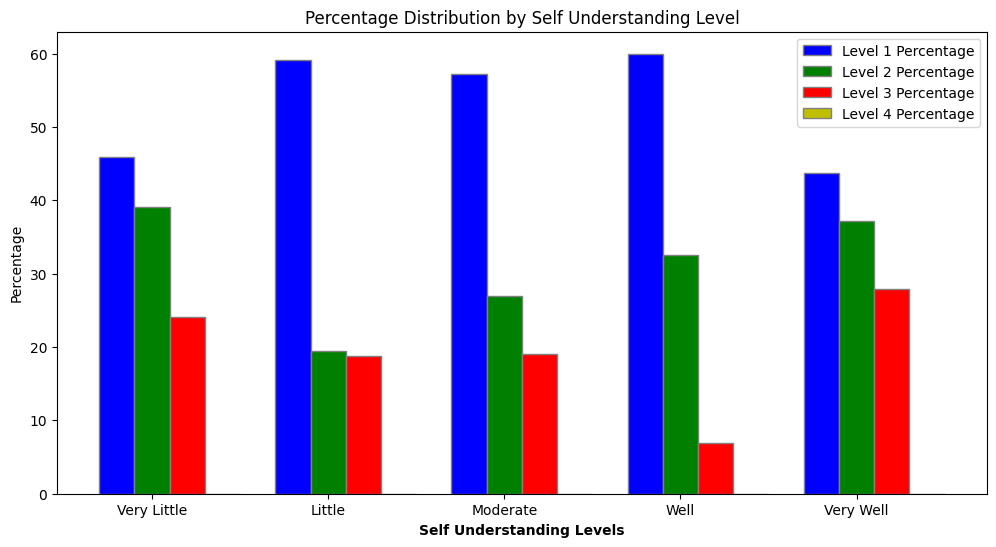

In [83]:
self_understanding_levels = ['Very Little', 'Little', 'Moderate', 'Well', 'Very Well']
level_1_percentage = [45.88, 59.21, 57.21, 60.00, 43.79]
level_2_percentage = [39.12, 19.41, 27.03, 32.57, 37.24]
level_3_percentage = [24.12, 18.81, 19.03, 6.86, 27.93]
level_4_percentage = [0.00, 0.00, 0.00, 0.00, 0.00]  # All zeros

n = len(self_understanding_levels)

plt.figure(figsize=(12, 6))

barWidth = 0.2
r1 = np.arange(n)
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

plt.bar(r1, level_1_percentage, color='b', width=barWidth, edgecolor='grey', label='Level 1 Percentage')
plt.bar(r2, level_2_percentage, color='g', width=barWidth, edgecolor='grey', label='Level 2 Percentage')
plt.bar(r3, level_3_percentage, color='r', width=barWidth, edgecolor='grey', label='Level 3 Percentage')
plt.bar(r4, level_4_percentage, color='y', width=barWidth, edgecolor='grey', label='Level 4 Percentage')

plt.xlabel('Self Understanding Levels', fontweight='bold')
plt.xticks([r + barWidth for r in range(n)], self_understanding_levels)
plt.ylabel('Percentage')
plt.title('Percentage Distribution by Self Understanding Level')

plt.legend()
plt.show()

### Semantic Level by Difficulty Breakdown

In [76]:
difficulty = df['difficulty_rating'].unique().tolist()
difficulty

[4, 5, 2, 3, 1]

In [79]:
for diff in difficulty:
    filtered_df = df[df['difficulty_rating'] == diff]
    descriptions = filtered_df['descriptions'].tolist()
    corpus_count = 1000
    all_sentences = []
    for desc in descriptions:
        sentences = re.split(r"(?<=\.)(\s)(?=[A-Z])", desc)
        formatted_sentence = [i for i in sentences if i != " "]
        for i in range(len(formatted_sentence)//2+1):
          sent_id = int(2*i)
          all_sentences.append({
              "corpus_id":corpus_count,
              "sent_id":int(i),
              "text": sentences[sent_id]+sentences[sent_id+1] if i!= len(sentences)//2 else sentences[sent_id],
              "labels":[-1, -1, -1, -1]
          })
        corpus_count+=1 
    predictions = torch.zeros(len(all_sentences),4)
    for i,sentence in enumerate(all_sentences):
        tokenized_input = tokenizer.encode(sentence['text'], max_length=512)
        input_ids = torch.tensor([tokenized_input])
        aggregated_predictions = torch.zeros(1, 4) 
        
        for j in range(5):
            model = models[j]
            with torch.no_grad():
                all = model(input_ids=input_ids, labels=sentence['labels'])
                logits = all[1]
                aggregated_predictions += torch.round(logits)
        average_predictions = aggregated_predictions / 5
        predictions[i]=average_predictions
    print(f"Total Examples from Difficulty Level {diff}: {predictions.shape[0]}")
    print(f"Level 1 Percentage: {100 * torch.sum(predictions[:, 0]) / predictions.shape[0]:.2f}%")
    print(f"Level 2 Percentage: {100 * torch.sum(predictions[:, 1]) / predictions.shape[0]:.2f}%")
    print(f"Level 3 Percentage: {100 * torch.sum(predictions[:, 2]) / predictions.shape[0]:.2f}%")
    print(f"Level 4 Percentage: {100 * torch.sum(predictions[:, 3]) / predictions.shape[0]:.2f}%")
    print('done.')

Total Examples from Level 4: 164
Level 1 Percentage: 55.24%
Level 2 Percentage: 29.39%
Level 3 Percentage: 20.73%
Level 4 Percentage: 0.00%
done.
Total Examples from Level 5: 126
Level 1 Percentage: 56.51%
Level 2 Percentage: 25.40%
Level 3 Percentage: 17.94%
Level 4 Percentage: 0.00%
done.
Total Examples from Level 2: 113
Level 1 Percentage: 47.79%
Level 2 Percentage: 40.88%
Level 3 Percentage: 15.22%
Level 4 Percentage: 0.00%
done.
Total Examples from Level 3: 119
Level 1 Percentage: 58.15%
Level 2 Percentage: 27.56%
Level 3 Percentage: 12.27%
Level 4 Percentage: 0.00%
done.
Total Examples from Level 1: 45
Level 1 Percentage: 68.44%
Level 2 Percentage: 22.67%
Level 3 Percentage: 14.67%
Level 4 Percentage: 0.00%
done.


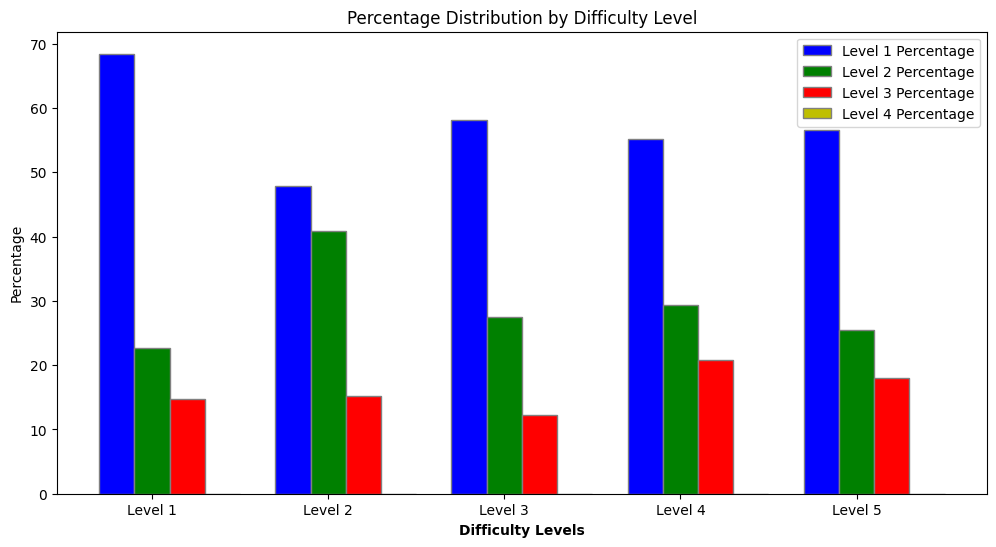

In [82]:
import matplotlib.pyplot as plt
import numpy as np

difficulty_levels = ['Level 1', 'Level 2', 'Level 3', 'Level 4', 'Level 5']
level_1_percentage = [68.44, 47.79, 58.15, 55.24, 56.51] 
level_2_percentage = [22.67, 40.88, 27.56, 29.39, 25.40]
level_3_percentage = [14.67, 15.22, 12.27, 20.73, 17.94]
level_4_percentage = [0.00, 0.00, 0.00, 0.00, 0.00]

n = len(difficulty_levels)

plt.figure(figsize=(12, 6))

barWidth = 0.2
r1 = np.arange(n)
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

plt.bar(r1, level_1_percentage, color='b', width=barWidth, edgecolor='grey', label='Level 1 Percentage')
plt.bar(r2, level_2_percentage, color='g', width=barWidth, edgecolor='grey', label='Level 2 Percentage')
plt.bar(r3, level_3_percentage, color='r', width=barWidth, edgecolor='grey', label='Level 3 Percentage')
plt.bar(r4, level_4_percentage, color='y', width=barWidth, edgecolor='grey', label='Level 4 Percentage')

plt.xlabel('Difficulty Levels', fontweight='bold')
plt.xticks([r + barWidth for r in range(n)], difficulty_levels)
plt.ylabel('Percentage')
plt.title('Percentage Distribution by Difficulty Level')

plt.legend()
plt.show()

### Semantic Level by MiniVLAT scores breakdown

In [92]:
scores = df['minivlat_score'].unique().tolist()
scores.sort()
scores

[5, 6, 7, 8, 9, 10, 11, 12]

In [93]:
for score in scores:
    filtered_df = df[df['minivlat_score'] == score]
    descriptions = filtered_df['descriptions'].tolist()
    corpus_count = 1000
    all_sentences = []
    for desc in descriptions:
        sentences = re.split(r"(?<=\.)(\s)(?=[A-Z])", desc)
        formatted_sentence = [i for i in sentences if i != " "]
        for i in range(len(formatted_sentence)//2+1):
          sent_id = int(2*i)
          all_sentences.append({
              "corpus_id":corpus_count,
              "sent_id":int(i),
              "text": sentences[sent_id]+sentences[sent_id+1] if i!= len(sentences)//2 else sentences[sent_id],
              "labels":[-1, -1, -1, -1]
          })
        corpus_count+=1 
    predictions = torch.zeros(len(all_sentences),4)
    for i,sentence in enumerate(all_sentences):
        tokenized_input = tokenizer.encode(sentence['text'], max_length=512)
        input_ids = torch.tensor([tokenized_input])
        aggregated_predictions = torch.zeros(1, 4) 
        
        for j in range(5):
            model = models[j]
            with torch.no_grad():
                all = model(input_ids=input_ids, labels=sentence['labels'])
                logits = all[1]
                aggregated_predictions += torch.round(logits)
        average_predictions = aggregated_predictions / 5
        predictions[i]=average_predictions
    print(f"Total Examples from MiniVLAT score {score}: {predictions.shape[0]}")
    print(f"Level 1 Percentage: {100 * torch.sum(predictions[:, 0]) / predictions.shape[0]:.2f}%")
    print(f"Level 2 Percentage: {100 * torch.sum(predictions[:, 1]) / predictions.shape[0]:.2f}%")
    print(f"Level 3 Percentage: {100 * torch.sum(predictions[:, 2]) / predictions.shape[0]:.2f}%")
    print(f"Level 4 Percentage: {100 * torch.sum(predictions[:, 3]) / predictions.shape[0]:.2f}%")
    print('done.')

Total Examples from MiniVLAT score 5: 7
Level 1 Percentage: 65.71%
Level 2 Percentage: 11.43%
Level 3 Percentage: 8.57%
Level 4 Percentage: 0.00%
done.
Total Examples from MiniVLAT score 6: 11
Level 1 Percentage: 40.00%
Level 2 Percentage: 40.00%
Level 3 Percentage: 9.09%
Level 4 Percentage: 0.00%
done.
Total Examples from MiniVLAT score 7: 15
Level 1 Percentage: 37.33%
Level 2 Percentage: 36.00%
Level 3 Percentage: 22.67%
Level 4 Percentage: 0.00%
done.
Total Examples from MiniVLAT score 8: 37
Level 1 Percentage: 81.62%
Level 2 Percentage: 11.89%
Level 3 Percentage: 2.70%
Level 4 Percentage: 0.00%
done.
Total Examples from MiniVLAT score 9: 122
Level 1 Percentage: 58.20%
Level 2 Percentage: 24.75%
Level 3 Percentage: 20.33%
Level 4 Percentage: 0.00%
done.
Total Examples from MiniVLAT score 10: 171
Level 1 Percentage: 55.91%
Level 2 Percentage: 31.93%
Level 3 Percentage: 10.18%
Level 4 Percentage: 0.00%
done.
Total Examples from MiniVLAT score 11: 159
Level 1 Percentage: 54.84%
Level 2

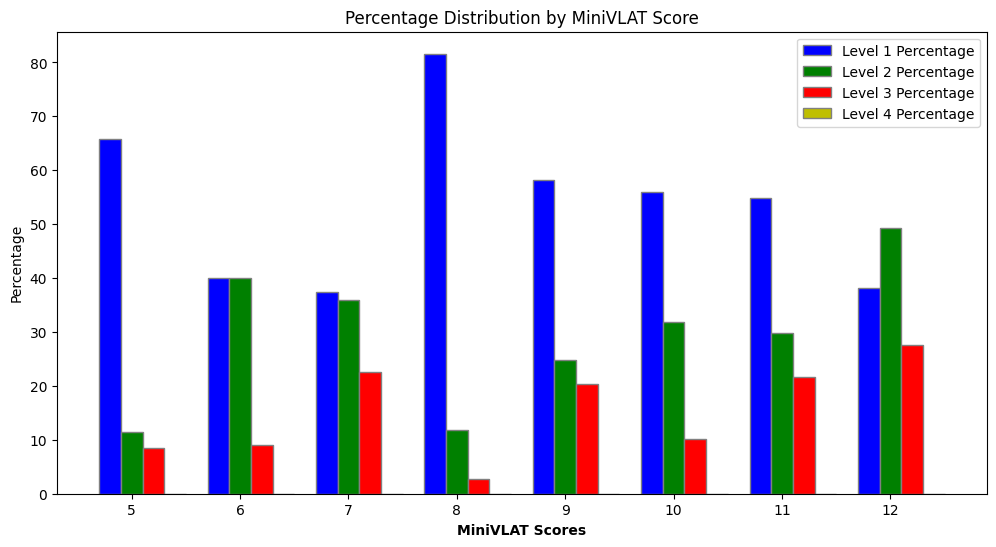

In [94]:
minivlat_scores = ['5', '6', '7', '8', '9', '10', '11', '12']
level_1_percentage = [65.71, 40.00, 37.33, 81.62, 58.20, 55.91, 54.84, 38.22]
level_2_percentage = [11.43, 40.00, 36.00, 11.89, 24.75, 31.93, 29.81, 49.33]
level_3_percentage = [8.57, 9.09, 22.67, 2.70, 20.33, 10.18, 21.64, 27.56]
level_4_percentage = [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]  

n = len(minivlat_scores)

plt.figure(figsize=(12, 6))

barWidth = 0.2
r1 = np.arange(n)
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

plt.bar(r1, level_1_percentage, color='b', width=barWidth, edgecolor='grey', label='Level 1 Percentage')
plt.bar(r2, level_2_percentage, color='g', width=barWidth, edgecolor='grey', label='Level 2 Percentage')
plt.bar(r3, level_3_percentage, color='r', width=barWidth, edgecolor='grey', label='Level 3 Percentage')
plt.bar(r4, level_4_percentage, color='y', width=barWidth, edgecolor='grey', label='Level 4 Percentage')

plt.xlabel('MiniVLAT Scores', fontweight='bold')
plt.xticks([r + barWidth for r in range(n)], minivlat_scores)
plt.ylabel('Percentage')
plt.title('Percentage Distribution by MiniVLAT Score')

plt.legend()
plt.show()